In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("../mpi_scripts/")
from io_utils import collect_results

# Load results

In [2]:
case = "210720_165224"
dirname_results = '../../results/ina'
result = collect_results(case, dirname_results, dump_keys=['best'])

In [3]:
config = result['config'].copy()
sol_best = result['sol_best'].copy()
phenotype_best = result['phenotype_best'].copy()
sol_best.round(2)

ec_name  g_name
common   c_p       2.34
trace    c_m       1.08
Name: 0, dtype: float64

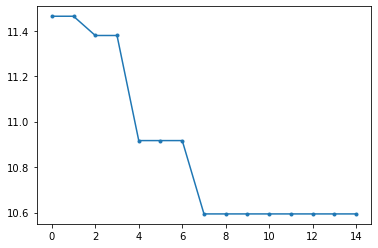

In [4]:
loss = result['dump']['best']['loss']
plt.plot(loss, '.-')

In [5]:
dump_genes = pd.DataFrame(result['dump']['best']['genes'].reshape(-1, len(sol_best)),
                          columns=config['runtime']['m_index'])
dump_genes

ec_name,common,trace
g_name,c_p,c_m
0,0.116429,1.088084
1,7.158654,1.448509
2,2.941520,1.060793
3,0.499161,6.219557
4,0.277883,1.091114
5,0.140526,3.592669
6,0.277883,1.091114
7,2.339084,1.079514
8,2.686231,8.018496


# Recreate solution

In [6]:
sys.path.append('src/model')
from ina_model import InaModel
from solmodel import SolModel

In [8]:
filename_so = config['runtime']['filename_so_abs']
model = InaModel(filename_so)

SolModel.model = model
SolModel.config = config.copy()

sol = SolModel(x=sol_best)

In [9]:
sol.update()

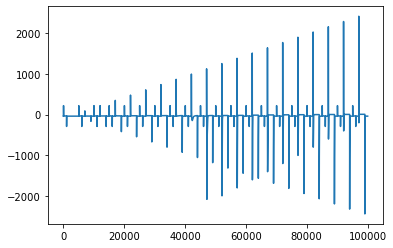

In [13]:
plt.plot(sol['phenotype']['trace']['I_out'])